In [1]:
import torch
import json
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, json_path, tokenizer, max_length=512):
        """
        Args:
            json_path (str): Path to JSON file containing triplets
            tokenizer: HuggingFace tokenizer
            max_length (int): Maximum sequence length for tokenization
        """
        # Load JSON data
        with open(json_path, 'r') as f:
            self.data = json.load(f)
            
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get single triplet example
        item = self.data[idx]
        
        # Tokenize the query
        query_encoding = self.tokenizer(
            item['question'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Convert embeddings to tensors
        # Assuming embeddings in JSON are stored as lists or arrays
        positive_emb = torch.tensor(item['positive'], dtype=torch.float)
        negative_emb = torch.tensor(item['negative'], dtype=torch.float)
        
        return {
            'query_ids': query_encoding['input_ids'].squeeze(),
            'query_mask': query_encoding['attention_mask'].squeeze(),
            'positive_embedding': positive_emb,
            'negative_embedding': negative_emb
        }
    
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.cosine = nn.CosineSimilarity(dim=1)
        
    def forward(self, anchor, positive, negative):
        # Compute cosine similarities
        similarity_positive = self.cosine(anchor, positive)  # Higher means more similar
        similarity_negative = self.cosine(anchor, negative)  # Higher means more similar
        
        # Loss = max(0, margin - (pos_sim - neg_sim))
        # We want positive similarity to be higher than negative similarity by at least the margin
        losses = torch.relu(self.margin - (similarity_positive - similarity_negative))
        
        return losses.mean()
    
class TripletBERTModel(nn.Module):
    def __init__(self, model_name='allenai/scibert_scivocab_uncased', freeze_layers=True):
        super(TripletBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
        if freeze_layers:
            # Freeze all layers except the last transformer layer
            for name, param in self.bert.named_parameters():
                if "encoder.layer.11" not in name:  # 11 is the last layer (0-11)
                    param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]

c:\Users\pilug\Documents\PaperSemanticSearch\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tqdm import tqdm


losses = []


def train_model(model, train_loader, num_epochs, learning_rate, device):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = TripletLoss()
    
    model.train()
    
    # epoch_pbar = tqdm(range(num_epochs), desc='Epochs', position=0)

    for epoch in range(num_epochs):
        total_loss = 0
        # Create batch progress bar
        batch_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}', 
                         leave=False, position=0)
        
        for batch in batch_pbar:
            # Move batch to device
            query_ids = batch['query_ids'].to(device)
            query_mask = batch['query_mask'].to(device)
            positive_emb = batch['positive_embedding'].to(device)
            negative_emb = batch['negative_embedding'].to(device)
            
            # Get query embedding
            query_emb = model(query_ids, query_mask)
            
            # Calculate loss using pre-encoded embeddings
            loss = criterion(query_emb, positive_emb, negative_emb)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Update batch progress bar
            batch_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        # Update epoch progress bar
        # epoch_pbar.set_postfix({'avg_loss': f'{avg_loss:.4f}'})
    
    return model

In [3]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
dataset = TripletDataset(
        json_path='triplets.json',
        tokenizer=tokenizer
    )
    
# Create dataloader
train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

In [5]:
model = TripletBERTModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model = train_model(
        model=model,
        train_loader=train_loader,
        num_epochs=100,
        learning_rate=2e-5,
        device=device
    )
    
# Save the model
torch.save(model.state_dict(), 'triplet_scibert.pt')

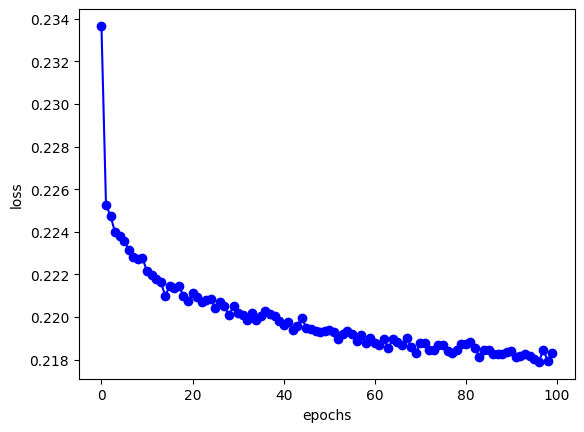

In [15]:
import matplotlib.pyplot as plt

# Plot the list
plt.plot(losses, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('loss')

# Show the plot
plt.show()


# Testing

In [4]:
# Load the model architecture and weights
model = TripletBERTModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load the saved weights
model.load_state_dict(torch.load('triplet_scibert.pt', map_location=device))
model.eval()  # Set the model to evaluation mode

C:\Users\pilug\AppData\Local\Temp\ipykernel_19128\3206792247.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('triplet_scibert.pt', map_l

TripletBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [6]:
from transformers import AutoTokenizer
import pandas as pd
import torch.nn.functional as F

# Load the same tokenizer used during training
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

# Define a function to generate the embedding for a given text
def generate_embedding(text, model, tokenizer, device):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Generate the embedding
    with torch.no_grad():
        embedding = model(input_ids, attention_mask)
    return embedding

# Define a function to find the most similar paper
def find_most_similar_paper(query, model, tokenizer, paper_embeddings, device):
    # Generate query embedding
    query_embedding = generate_embedding(query, model, tokenizer, device)  # Shape: (1, embedding_dim)

    # Compute cosine similarities
    similarities = F.cosine_similarity(query_embedding, paper_embeddings, dim=1)  # Shape: (num_papers,)
    
    # Find the most similar paper
    best_match_idx = torch.argmax(similarities).item()
    best_match_similarity = similarities[best_match_idx].item()
    
    return best_match_idx, best_match_similarity

def get_similar_papers(paper, embeddings, top_k = 3):
    similarities = F.cosine_similarity(paper, embeddings)
    top_indices = similarities.argsort()[-top_k - 1:]

    return top_indices.tolist()[:-1]

# Load precomputed embeddings for your papers (e.g., from a .pt file)
paper_embeddings = torch.stack(torch.load('embeddings.pt')).to(device).squeeze(1)  # Shape: (num_papers, embedding_dim)
papers = pd.read_json('papers.json', orient='records', lines=True)

C:\Users\pilug\AppData\Local\Temp\ipykernel_19128\2609320156.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  paper_embeddings = torch.stack(torch.load('embeddings.pt'))

In [28]:
query = "How will quantum computing affect blockchain currencies and crytocurrencies?"

# Find the most similar paper
idx, best_match_similarity = find_most_similar_paper(
    query, model, tokenizer, paper_embeddings, device
)

print(f"Best match: {papers.iloc[idx]['summary']}")
print(f"Similarity: {best_match_similarity:.4f}")

Best match: We introduce a new cryptographic protocol, called Deep Ocean, that implements
a blockchain-agnostic dark pool for cryptocurrencies. Deep Ocean is a layer-two
protocol, meaning that it can work with any two cryptocurrencies, as long as
there exists an underlying settlement mechanism, for example performing atomic
swaps.
Similarity: 0.4494


In [29]:
idices = get_similar_papers(paper_embeddings[idx], paper_embeddings)

for i in idices: 
    print(papers.iloc[i]['title'])

Anonymous State Pinning for Private Blockchains
Cross-Blockchain Communication Using Oracles With an Off-Chain
  Aggregation Mechanism Based on zk-SNARKs
Testimonium: A Cost-Efficient Blockchain Relay


: 